<a href="https://colab.research.google.com/github/willywonka68/Octa_10_Vulcan/blob/main/Pesticide_Control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pesticide Control and Optimisation** 

Please note: In order to run the code we recommend to *download the dataset files* from the repository and *add it to the files* section before running the notebook.

In [ ]:
#importing important libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score,KFold,StratifiedKFold,RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV

In [ ]:
#Reading the train and test data
train = pd.read_csv("/content/train_yaOffsB_pesticide.txt")
test  = pd.read_csv("/content/test_pFkWwen_pesticide.txt")

#Make sure the proper path is copied from the files section within the notebook 

In [ ]:
"Training Data Shape:{}".format(train.shape),"Testing Data Shape:{}".format(test.shape) 

('Training Data Shape:(88858, 10)', 'Testing Data Shape:(59310, 9)')

In [ ]:
#Dropping the unrequired feature
Submission = test[['ID']]
train.drop("ID",axis=1,inplace=True)
test.drop('ID',axis=1,inplace=True)

 **Exploratory Data Analysis**



In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88858 entries, 0 to 88857
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Estimated_Insects_Count  88858 non-null  int64  
 1   Crop_Type                88858 non-null  int64  
 2   Soil_Type                88858 non-null  int64  
 3   Pesticide_Use_Category   88858 non-null  int64  
 4   Number_Doses_Week        88858 non-null  int64  
 5   Number_Weeks_Used        79858 non-null  float64
 6   Number_Weeks_Quit        88858 non-null  int64  
 7   Season                   88858 non-null  int64  
 8   Crop_Damage              88858 non-null  int64  
dtypes: float64(1), int64(8)
memory usage: 6.1 MB


In [ ]:
#Dropping the null values
train.dropna(inplace=True)
train.isnull().sum()

Estimated_Insects_Count    0
Crop_Type                  0
Soil_Type                  0
Pesticide_Use_Category     0
Number_Doses_Week          0
Number_Weeks_Used          0
Number_Weeks_Quit          0
Season                     0
Crop_Damage                0
dtype: int64

**Data Preaparation and Encoding**

In [ ]:
train.head()

,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
0,188,1,0,1,0,0.0,0,1,0
1,209,1,0,1,0,0.0,0,2,1
2,257,1,0,1,0,0.0,0,2,1
3,257,1,1,1,0,0.0,0,2,1
4,342,1,0,1,0,0.0,0,2,1


In [ ]:
train['Crop_Damage'].value_counts(dropna=False)/len(train)

0    0.835771
1    0.138483
2    0.025746
Name: Crop_Damage, dtype: float64

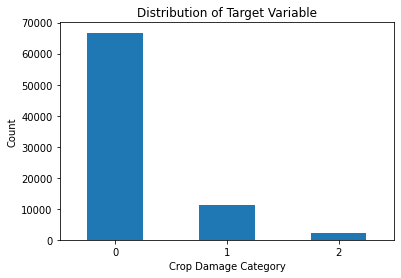

In [ ]:
train['Crop_Damage'].value_counts(dropna=False).plot.bar();
plt.title("Distribution of Target Variable");
plt.xlabel("Crop Damage Category");
plt.ylabel("Count");
plt.xticks(rotation=360);

0 - Alive, 1 - Damage due to other causes, 2 - damage due to pesticide


<Figure size 864x360 with 0 Axes>

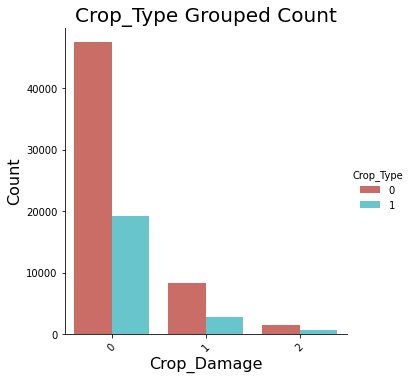

In [ ]:
plt.figure(figsize=(12,5))
sns.catplot(x='Crop_Damage', data=train, palette="hls",kind='count',hue='Crop_Type')
plt.xlabel("Crop_Damage", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Crop_Type Grouped Count", fontsize=20)
plt.xticks(rotation=45)
plt.show()

Observations from the Univariate Analysis are :

Crop damage due to pesticides are less in comparison to damage due to other causes.
Crop type 0 has higher chance of survival compared to crop type 1.


Text(0.5, 1.0, 'Crop Damage vs Pesticide Use Category ')

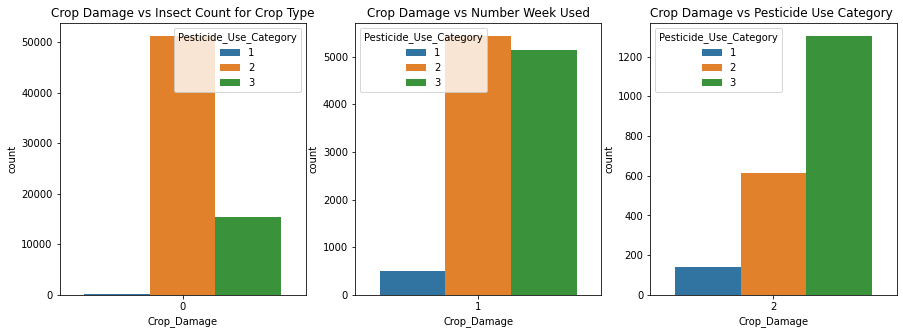

In [ ]:
fig, [ax1,ax2,ax3] = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
ax1=sns.countplot(x="Crop_Damage" ,hue="Pesticide_Use_Category",data=train[train["Crop_Damage"]==0],ax=ax1)
ax1.set_title("Crop Damage vs Insect Count for Crop Type")
ax2=sns.countplot(x="Crop_Damage" ,hue="Pesticide_Use_Category",data=train[train["Crop_Damage"]==1],ax=ax2)
ax2.set_title("Crop Damage vs Number Week Used")
ax3=sns.countplot(x="Crop_Damage" ,hue="Pesticide_Use_Category",data=train[train["Crop_Damage"]==2],ax=ax3)
ax3.set_title("Crop Damage vs Pesticide Use Category ")

Observations:

Type 2 pesticide is much safer to use as compared to Type 3 pesticide.

Type 3 pesticide shows most pesticide related damage to crops.

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated

<Figure size 864x360 with 0 Axes>

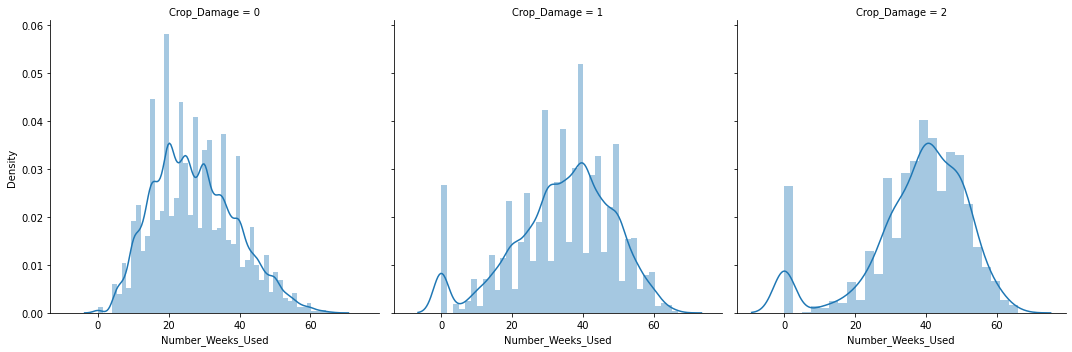

In [ ]:
plt.figure(figsize=(12,5))
g= sns.FacetGrid(train, col='Crop_Damage',size=5)
g = g.map(sns.distplot, "Number_Weeks_Used")
plt.show()

Observations:

From Graph 1 we can conclude that till 20-25 weeks damage due to pesticide is negligible.

From Graph 3 we can see that after 20 weeks damage due to use of pesticide increrases significantly.

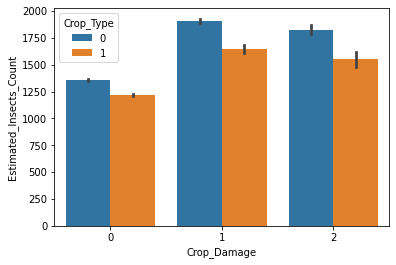

In [ ]:
sns.barplot(x="Crop_Damage" ,y="Estimated_Insects_Count",hue="Crop_Type",data=train)

Observations:

Clearly observed that Most insect attacks are done on crop type 0.

<Figure size 864x360 with 0 Axes>

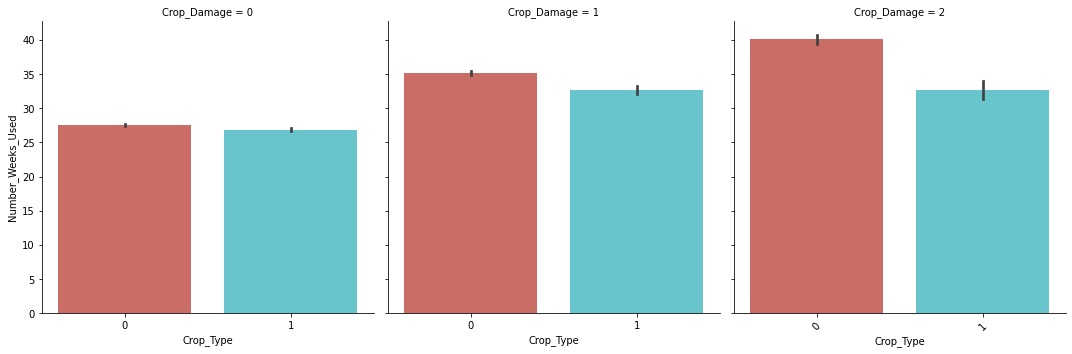

In [ ]:
plt.figure(figsize=(12,5))
sns.catplot(x='Crop_Type',y='Number_Weeks_Used', data=train, palette="hls",kind='bar',col='Crop_Damage')
plt.xticks(rotation=45)
plt.show()

Observations:

Crop Type 0 is more vulnerable to pesticide related and other damages as compared to Type1

Avg. duration of pesticide related damage is lower for Crop type 1.

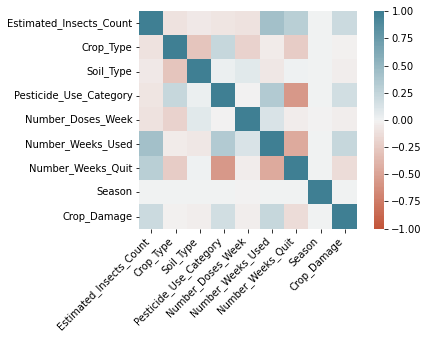

In [ ]:
corr = train.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Observations from the heatmaps are :

1.Estimated_Insects_count,Pesticide_use_category and Number_weeks_used are positively correlated with Crop damage.

2.Number_weeks_used is positively correlated with Estimated_Insects_count and Pesticide_use_category.

3.Number_weeks_Quit is highly negatively correlated with Pesticide_use_category and Number_weeks_used.

In [ ]:
train.describe()

,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
count,79858.000000,79858.000000,79858.000000,79858.000000,79858.000000,79858.000000,79858.000000,79858.000000,79858.000000
mean,1400.766060,0.283829,0.459503,2.264820,25.848381,28.623970,9.590636,1.896441,0.189975
std,850.268301,0.450858,0.498360,0.461764,15.544704,12.391881,9.902990,0.701498,0.453187
min,150.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,731.000000,0.000000,0.000000,2.000000,15.000000,20.000000,0.000000,1.000000,0.000000
50%,1212.000000,0.000000,0.000000,2.000000,20.000000,28.000000,7.000000,2.000000,0.000000
75%,1898.000000,1.000000,1.000000,3.000000,40.000000,37.000000,16.000000,2.000000,0.000000
max,4097.000000,1.000000,1.000000,3.000000,95.000000,67.000000,50.000000,3.000000,2.000000


Observations: 1.Clearly some outliers are present in Insect_Count ,doses_week and number_weeks_quit columns

Estimated_Insects_Count       AxesSubplot(0.125,0.749828;0.133621x0.130172)
Crop_Type                  AxesSubplot(0.285345,0.749828;0.133621x0.130172)
Soil_Type                   AxesSubplot(0.44569,0.749828;0.133621x0.130172)
Pesticide_Use_Category     AxesSubplot(0.606034,0.749828;0.133621x0.130172)
Number_Doses_Week          AxesSubplot(0.766379,0.749828;0.133621x0.130172)
Number_Weeks_Used             AxesSubplot(0.125,0.593621;0.133621x0.130172)
Number_Weeks_Quit          AxesSubplot(0.285345,0.593621;0.133621x0.130172)
Season                      AxesSubplot(0.44569,0.593621;0.133621x0.130172)
Crop_Damage                AxesSubplot(0.606034,0.593621;0.133621x0.130172)
dtype: object

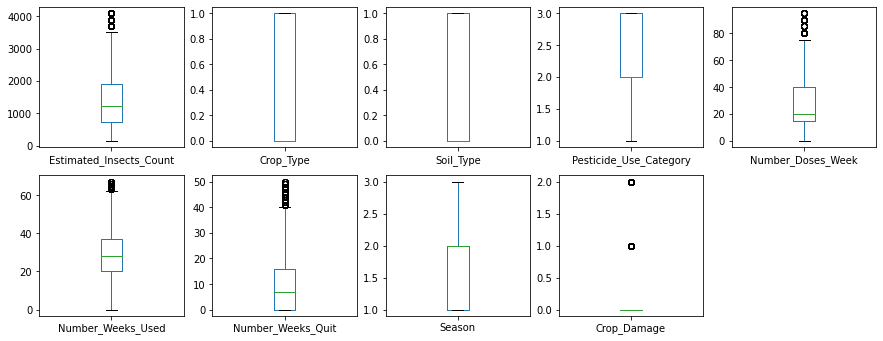

In [ ]:
#Now we will check for outliers using boxplot
train.plot(kind="box",subplots=True,layout=(5,5),figsize=(15,15))

In [ ]:
#now finding the mean value of each column and replacing with outlier value
train.loc[train['Number_Weeks_Used']>55,'Number_Weeks_Used'] = np.mean(train["Number_Weeks_Used"])
train.loc[train['Estimated_Insects_Count']>3500,'Estimated_Insects_Count'] = np.mean(train["Estimated_Insects_Count"])
train.loc[train['Number_Weeks_Quit']>40,'Number_Weeks_Quit'] = np.mean(train["Number_Weeks_Quit"])
train.loc[train['Number_Doses_Week']>80,'Number_Doses_Week'] = np.mean(train["Number_Doses_Week"])
    

Estimated_Insects_Count       AxesSubplot(0.125,0.749828;0.133621x0.130172)
Crop_Type                  AxesSubplot(0.285345,0.749828;0.133621x0.130172)
Soil_Type                   AxesSubplot(0.44569,0.749828;0.133621x0.130172)
Pesticide_Use_Category     AxesSubplot(0.606034,0.749828;0.133621x0.130172)
Number_Doses_Week          AxesSubplot(0.766379,0.749828;0.133621x0.130172)
Number_Weeks_Used             AxesSubplot(0.125,0.593621;0.133621x0.130172)
Number_Weeks_Quit          AxesSubplot(0.285345,0.593621;0.133621x0.130172)
Season                      AxesSubplot(0.44569,0.593621;0.133621x0.130172)
Crop_Damage                AxesSubplot(0.606034,0.593621;0.133621x0.130172)
dtype: object

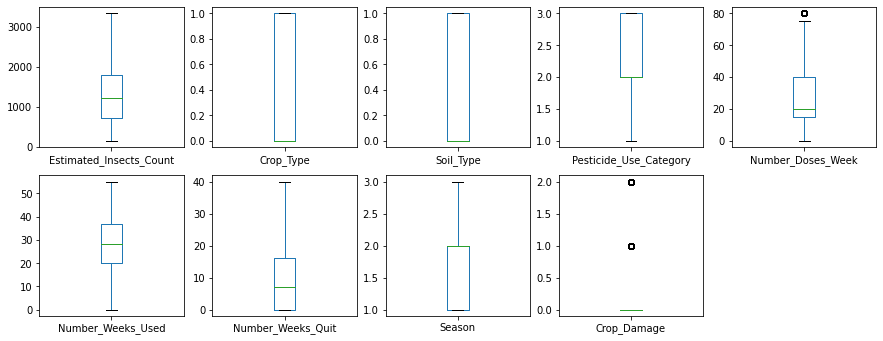

In [ ]:
#Now we will check for outliers using boxplot
train.plot(kind="box",subplots=True,layout=(5,5),figsize=(15,15))

#we can see that outliers have been removed in Total Volume , Large, Small and Total bags

Observations: 1.we can see that outliers have been removed in Insect_Count, Number_Doses_Weeks,Number_Weeks_Quit

In [ ]:
# Dropping region and Day from x for classifcation dataset
#Assigning the value of x for testing and training
df_xc=train.drop(columns=['Crop_Damage'])
yc=train[["Crop_Damage"]]

In [ ]:
#defining a function to find accuracy score, crossvalidation score for the given dataset
def max_acc_score(names,model_c,df_xc,yc):
    accuracy_scr_max = 0
    for r_state in range(42,100):
        train_xc,test_xc,train_yc,test_yc = train_test_split(df_xc,yc,random_state = r_state,test_size = 0.33,stratify = yc)
        model_c.fit(train_xc,train_yc)
        accuracy_scr = accuracy_score(test_yc,model_c.predict(test_xc))
        if accuracy_scr> accuracy_scr_max:
            accuracy_scr_max=accuracy_scr
            final_state = r_state
            final_model = model_c
            mean_acc = cross_val_score(final_model,df_xc,yc,cv=5,scoring="accuracy").mean()
            std_dev = cross_val_score(final_model,df_xc,yc,cv=5,scoring="accuracy").std()
            cross_val = cross_val_score(final_model,df_xc,yc,cv=5,scoring="accuracy")
    print('\033[1m',"Results for model : ",names,'\n','\033[0m'
          "max accuracy score is" , accuracy_scr_max ,'\n',
          "Mean accuracy score is : ",mean_acc,'\n',
          "Std deviation score is : ",std_dev,'\n',
          "Cross validation scores are :  " ,cross_val) 
    print("*"*100)

In [ ]:
accuracy_scr_max = []
accuracy=[]
std_dev=[]
mean_acc=[]
cross_val=[]
models=[]

models.append(('KNN', KNeighborsClassifier()))

for names,model_c in models:
    max_acc_score(names,model_c,df_xc,yc)


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

 Results for model :  KNN 
 max accuracy score is 0.8269712377627685 
 Mean accuracy score is :  0.8251646669631281 
 Std deviation score is :  0.0018740579785119942 
 Cross validation scores are :   [0.82663411 0.82475582 0.82412973 0.82781291 0.82249076]
****************************************************************************************************


In [ ]:
# Estimating best n_neighbors using grid search CV for KNeighborsClassifier

kNN=KNeighborsClassifier()
parameters={"n_neighbors":range(2,30)}
clf = GridSearchCV(kNN, parameters, cv=5,scoring="accuracy")
clf.fit(df_xc,yc)
clf.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

{'n_neighbors': 23}

In [ ]:
xc_train,xc_test,yc_train,yc_test=train_test_split(df_xc, yc,random_state = 80,test_size=0.20,stratify=yc)
kNN.fit(xc_train,yc_train)
yc_pred=kNN.predict(xc_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


accuracy score is :  0.822564487853744
classification report 
               precision    recall  f1-score   support

           0       0.86      0.95      0.90     13349
           1       0.36      0.19      0.25      2212
           2       0.12      0.01      0.02       411

    accuracy                           0.82     15972
   macro avg       0.45      0.39      0.39     15972
weighted avg       0.77      0.82      0.79     15972



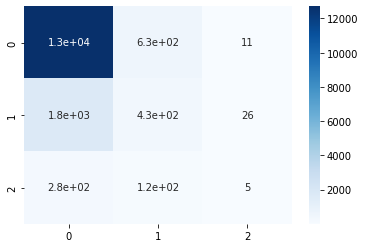

In [ ]:
print("accuracy score is : ",accuracy_score(yc_test,yc_pred))
print("classification report \n",classification_report(yc_test,yc_pred))

cnf = confusion_matrix(yc_test,yc_pred)
sns.heatmap(cnf, annot=True, cmap = "Blues")

Observations:

Due to abnormal distribution of data point -model is highly accurate in predicting no crop damage.

 **Conclusion**

Hence we have tested and trained the existing dataset using ML to determine optimum pesticide usage and its effect on crop yield and soil fertility.  
One point to be noted is that stable sensor data is difficult to obtain in rural areas of India where many problems arise such as accessibility, limited battery power, lack of internet, humidity/heat problem. So we have tried to use simple ML model for computation purposes. 